## Random Forest Classifier

In [68]:
import numpy as np
import cv2
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [69]:
def show_images(image):
    """
    image - image to be shown
    """

    fig, axes = plt.subplots(2, 4, figsize=(10, 6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(image)
        ax.set_title(image_files[i][:10])  # Set the title as the image filename
        ax.axis('off')  # Turn off axis labels

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [70]:
def ela(imagePath, scale=10, quality=90):
    """
    Performs Error Level Analysis (ELA) on an image.
    imagePath (str) - the path to the image file.
    scale (int) - the scale factor for resizing the image. Default is 10.

    Returns:
        elaImage (np.array) - the ELA image.
    """
    # Load the image
    image = cv2.imread(imagePath)

    # Resize the image
    resizedImage = cv2.resize(image, (scale, scale))

    # Convert the image to JPEG
    cv2.imwrite("temp.jpg", resizedImage, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Load the JPEG image and compute the ELA image
    elaImage = cv2.imread("temp.jpg")
    elaImage = cv2.absdiff(resizedImage, elaImage)
    elaImage = cv2.cvtColor(elaImage, cv2.COLOR_BGR2GRAY)

    return elaImage

In [71]:
def extract_features(elaImage):
    features = []
    features.append(np.mean(elaImage))
    features.append(np.std(elaImage))
    features.append(np.var(elaImage))
    
    # Histogram features
    hist = cv2.calcHist([elaImage], [0], None, [256], [0, 256])
    features.extend(hist.flatten()[:10])

    return np.array(features)


In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

def make_plot_of_results_of_grid_search_depends_on_param(algorithm_name,
                                                         hyperparam_name,
                                                         X_axis_label,
                                                         cv_results_,
                                                         *args):
    """
    algorithm_name: str - name of ML-algorithm
    hyperparam_name: str - name of hyperparam
    X_axis_label: str - name for OX axis
    cv_results_:dict of numpy (masked) ndarrays - cv_results_ from GridSearchCV
    """
    
    param_values = cv_results_['param_' + hyperparam_name].data
    is_str = isinstance(param_values[0], str)
    if is_str:
        le = LabelEncoder()
        param_values_labels = np.array(param_values).astype(str)
        param_values = le.fit_transform(param_values_labels)
    else:
        param_values = np.array(param_values).astype(float)
    
    mean_test_scores = cv_results_['mean_test_score']
    std_test_scores = cv_results_['std_test_score']
    mean_train_scores = cv_results_['mean_train_score']
    std_train_scores = cv_results_['std_train_score']

    plt.figure(figsize=(13, 6))
    plt.title(f"GridSearchCV curve {algorithm_name}")
    plt.xlabel(X_axis_label)
    plt.ylabel("Score f1")
    plt.ylim(0.0, 1.1)

    plt.plot(param_values, mean_test_scores, label="Test score",
             color="navy", lw=2)

    plt.fill_between(param_values, mean_test_scores - std_test_scores,
                     mean_test_scores + std_test_scores, alpha=0.2,
                     color="navy", lw=2, label="Standard error on test data")
    
    plt.plot(param_values, mean_train_scores, label="Training score",
             color="darkorange", lw=2)

    plt.fill_between(param_values, mean_train_scores - std_train_scores,
                     mean_train_scores + std_train_scores, alpha=0.2,
                     color="darkorange", lw=2, label="Standard error on train data")
    
    if is_str:
        plt.xticks(param_values, param_values_labels)
    plt.legend()

    plt.legend(loc="best")
    plt.show()

In [73]:
authentic = 'data/casia/au/'
tampered = 'data/casia/tp/'

In [74]:
# Mix photos
X = list()
Y = list()
for files in os.listdir(authentic):
    X.append(authentic+files)
    Y.append('Au')
for files in os.listdir(tampered):
    X.append(tampered+files)
    Y.append('Tp')
    
le = preprocessing.LabelEncoder()
y = le.fit_transform(Y)

In [75]:
X_a = []
y_a = []
for i, img_path in enumerate(X):
    ela_img = ela(img_path, scale=10, quality=90)
    features = extract_features(ela_img)
    X_a.append(features)
    y_a.append(y[i])  # Label: genuine (0) or tampered (1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [30, 20, 30],
    'max_depth': [1, 3, 7],
    'criterion': ['entropy', 'gini', 'log_loss']
}
clf = RandomForestClassifier(random_state=42)
tree_gs = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=2,
    return_train_score=True
)

In [76]:
tree_gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [1, 3, 7], 'n_estimators': [30, 20, 30]},
             return_train_score=True, scoring='f1', verbose=2)

[CV] END ....criterion=entropy, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=7, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......criterion=gini, max_depth=7, n_estimators=20; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=7, n_estimators=30; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END .......criterion=gini, max_depth=7, n_estimators=30; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END ....criterion=entro

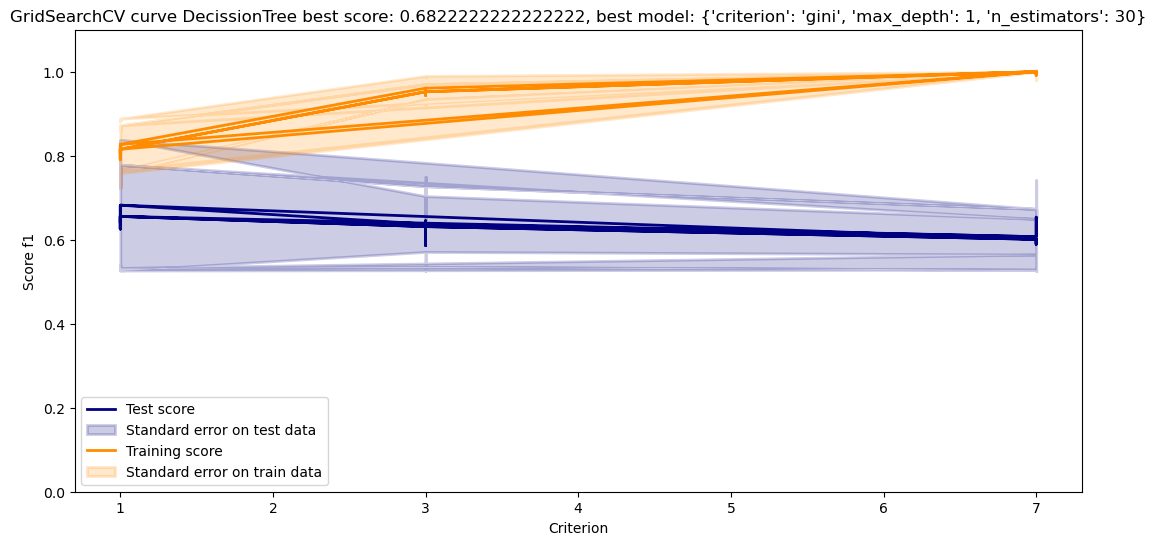

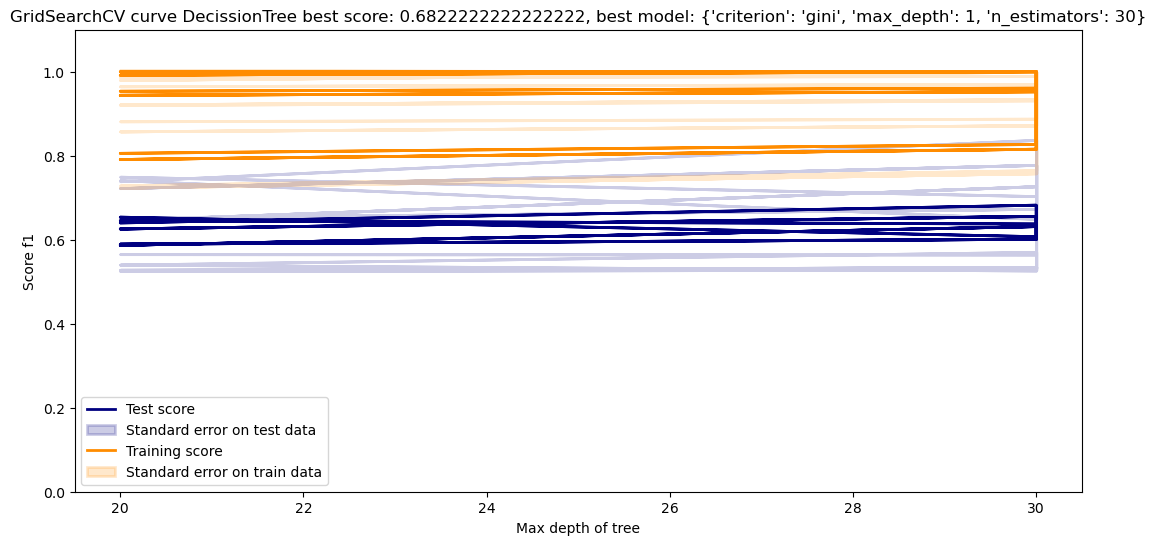

In [66]:
name = f'DecissionTree best score: {tree_gs.best_score_}, best model: {tree_gs.best_params_}'
make_plot_of_results_of_grid_search_depends_on_param(name, 'max_depth', 'Criterion', tree_gs.cv_results_)
make_plot_of_results_of_grid_search_depends_on_param(name, 'n_estimators', 'Max depth of tree', tree_gs.cv_results_)

In [67]:
# Evaluate
best_model = tree_gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.57      0.80      0.67         5

    accuracy                           0.73        15
   macro avg       0.72      0.75      0.72        15
weighted avg       0.77      0.73      0.74        15

[CV] END ....criterion=entropy, max_depth=1, n_estimators=30; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=7, n_estimators=20; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END .......criterion=gini, max_depth=7, n_estimators=30; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=1, n_estimators=10; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=7, n_estimators=30; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, n_estimators=20; total time=   0.0s
[CV] END .......criterion